## Introduction
This whole notebook should be run (<2min) to get inputs and outputs for modelling, mapping and decoding.

In [1]:
import time, ipywidgets, pickle, os
import numpy as np
import pandas as pd
from itertools import combinations, product
from scipy import stats, interpolate
import helper_functions as HF
import seaborn as sns
import matplotlib.pyplot as plt
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
np.seterr(divide='ignore')
pass

### Wind farm info
This snippets shows some info about the different sites

In [2]:
X_info = pd.read_excel('data/project_data.xlsx', sheet_name='site info DMI')
X_info

,Name,Country,lat,long,WTG type,No WTG,No blades,Inspections,Weather ID,Vin,Vr,Vout,RPM_min,RPM_max,Radius,Hub height,wsp scaler,Lvl height
0,Brorstrup,DK,56.7661,9.6134,S120/3600,2,6,"2012-01-01,2019-05-01",1,3.5,14.0,25,5.0,13.0,60,88,1,83.2
1,Løgtved,DK,55.6765,11.2743,V100/2000,3,9,"2016-06-01,2018-05-01,2019-05-01",2,3.5,12.0,22,7.0,13.4,50,78,1,83.2
2,Tween Bridge,GB,53.6666,-0.8899,V90/3000,22,66,"2012-03-01,2017-09-01",4,3.0,13.5,25,8.2,17.3,45,80,1,83.2
3,Märkische Heide,DE,51.9688,13.9799,V90/2000,8,24,"2009-05-01,2016-05-01,2019-05-01",6,3.0,13.5,25,8.2,17.3,45,125,1,136.0
4,Princess Amalia,NL,52.5900,4.2200,V80/2000,60,180,"2013-05-01,2018-05-01,2019-05-01,2020-05-01",7,3.5,14.5,25,9.0,19.0,40,59,1,58.7
5,Solberg,SW,63.7994,17.3943,V126/3450,22,66,"2018-01-01,2019-05-01,2020-05-01",49,4.5,11.5,22,5.0,13.0,63,117,1,108.8
6,Camster,GB,58.4060,-3.2624,V80/2000,25,75,"2013-07-01,2018-05-01",10,3.5,14.5,25,9.0,19.0,40,78,1,83.2


### Weather data stratification
We need to stratify our weather data so we have one input for inspection period.
This code prepares the weather data for each sample based on the inspection dates

In [3]:
# initialize empty dataframe to be appended
X_tt = pd.DataFrame()
# loop through all wind farms
for idx, row in X_info.iterrows():
    # load weather data for each wind farm based on weather file ID
    df = pd.read_csv('data/training/WF'+str(row['Weather ID'])+'_precip_WS_WD_extended_HHupdated.csv')
    # convert time column to datetime format
    try:
        df['time'] = pd.to_datetime(df['Unnamed: 0'])
    except:
        df['time'] = pd.to_datetime(df['time'])
    # set time column as index
    df.set_index('time',inplace=True)
    # loop through all unique periods
    for i in list(combinations(row['Inspections'].split(','), 2)):
        # prepare inputs using the helper function
        cols = HF.prepare_inputs(df, i, row, z_lvl=row['Lvl height'], tbi=3600)
        # append inputs to dataframe
        X_tt = X_tt.append(cols, ignore_index=True)
X_tt

,WF,start date,end date,months,t_scaler,prec_sum,ws_sum,tke_sum,prec_mean,ws_mean,tke_mean,impingement,da_inc
0,Brorstrup,2012-01-01,2019-05-01,88.0,1.26,6433.538273,461307.060595,58078.544265,0.128985,9.248708,1.164412,96.005915,0.786705
1,Løgtved,2016-06-01,2018-05-01,23.0,1.00,1237.562318,143919.129525,9064.112082,0.075319,8.759000,0.551647,20.541667,0.116657
2,Løgtved,2016-06-01,2019-05-01,35.0,1.00,1758.937686,210339.803826,16799.441743,0.070147,8.388427,0.669968,29.199881,0.156682
3,Løgtved,2018-05-01,2019-05-01,12.0,1.00,521.375368,66430.016633,7735.568618,0.060309,7.684212,0.894803,8.658213,0.040025
4,Tween Bridge,2012-03-01,2017-09-01,66.0,1.33,3523.168521,300681.228387,35457.630242,0.099999,8.534322,1.006404,52.078595,0.299888
5,Märkische Heide,2009-05-01,2016-05-01,84.0,2.49,4106.410059,415622.383524,41458.311973,0.170809,17.288066,1.724484,62.552778,0.585163
6,Märkische Heide,2009-05-01,2019-05-01,120.0,1.72,5866.043133,592357.076532,57021.883915,0.117617,11.877072,1.143319,90.353759,0.829741
7,Märkische Heide,2016-05-01,2019-05-01,36.0,1.00,1759.152528,177269.203133,16480.181809,0.068094,6.861857,0.637926,27.376590,0.247092
8,Princess Amalia,2013-05-01,2018-05-01,60.0,1.04,4119.002753,383803.786882,20797.127892,0.100434,9.358329,0.507099,71.582376,1.226624
9,Princess Amalia,2013-05-01,2019-05-01,72.0,1.03,4711.439212,460751.225546,23564.837998,0.094991,9.289527,0.475107,82.377549,1.416901


### Prepare inputs for visual sanity check
This section prepares an input file with a precomputed variable space that can be used as a look-up table for fast physicality checks.

In [4]:
alpha = 0.143
WF_list = ['Princess Amalia', 'Märkische Heide', 'Solberg']
dates = pd.date_range(start='2012-12-31', end='2023-01-01', freq='6M')
months = [date_obj.strftime('%Y-%m-%d') for date_obj in dates]
W0_range = np.arange(0, 0.51, 0.02)
counter = 0
results = pd.DataFrame()
for idx, row in X_info[X_info['Name'].isin(WF_list)].iterrows():
    df = pd.read_csv('data/training/WF'+str(row['Weather ID'])+'_precip_WS_WD_extended_HHupdated.csv')
    # convert time column to datetime format
    try:
        df['time'] = pd.to_datetime(df['Unnamed: 0'])
    except:
        df['time'] = pd.to_datetime(df['time'])
    # set time column as index
    df.set_index('time',inplace=True)
    for i in months:
        cols = HF.prepare_inputs(df, ('2013-01-01', i), row, z_lvl=row['Lvl height'], tbi=3600) # DMI
        for j in W0_range:
            cols['W0'] = j
            cols['W02'] = j
            results = results.append(cols, ignore_index=True)
            counter += 1
            print('Running iteration', counter, 'out of', len(WF_list)*len(months)*len(W0_range), end='\r')
results.to_csv('data/sanity_check_inputs_DMI.csv', index=False)

### Defect analysis
This section manually loads all the inspection files and organizes the defects so they have common columns and can be merged.

In [5]:
# Defining common format for all WFs
X_raw = pd.DataFrame(columns=['WF',
                              'year',
                              'WTG ID',
                              'Blade',
                              'Vertical distance',
                              'Type',
                              'Severity',
                              'Surface area',
                              'Layer'])

path_name = 'data/inspections/'
##### WF1 Brorstrup 2019 #####
folder_name = 'Brorstrup 2019/'
fnames = os.listdir(path_name+folder_name)
for file in fnames:
    df = pd.read_excel(path_name+folder_name+file)
    df = df.drop_duplicates(subset=['Defect Id'])
    tmp = pd.DataFrame()
    tmp['WF'] = df['Windfarm'].values
    tmp['year'] = '2019'
    tmp['WTG ID'] = df['Turbine'].values
    tmp['Blade'] = df['Blade'].values
    tmp['Vertical distance'] = df['Vertical Distance'].values
    tmp['Type'] = df['Defect Type'].values
    tmp['Severity'] = df['Severity'].values
    tmp['Surface area'] = df['Surface Area'].values
    tmp['Layer'] = df['Layer'].values
    tmp['maxRPM'] = 13
    X_raw = X_raw.append(tmp, ignore_index=True)

##### WF2 Løgtved 2018 #####
folder_name = 'Loegtved 2018/'
fnames = os.listdir(path_name+folder_name)
for file in fnames:
    df = pd.read_excel(path_name+folder_name+file)
    for wtg in df['Turbine'].unique():
        tmp = df[df['Turbine']==wtg]
        for blade in tmp['Blade'].unique():
            tmp1 = tmp[tmp['Blade']==blade]
            tmp1 = tmp1.drop_duplicates(subset=['DefectId'])
            tmp2 = pd.DataFrame()
            tmp2['Blade'] = tmp1['Blade'].values
            tmp2['WTG ID'] = 'WTG 01'
            tmp2['year'] = '2018'
            tmp2['WF'] = 'Løgtved'
            tmp2['Vertical distance'] = tmp1['Vertical_Distance'].values
            tmp2['Type'] = tmp1['DefectType'].values
            tmp2['Severity'] = tmp1['Severity'].values
            tmp2['Surface area'] = tmp1['Side'].values
            tmp2['Layer'] = tmp1['Layer'].values
            tmp2['maxRPM'] = 13.4
            X_raw = X_raw.append(tmp2, ignore_index=True)

##### WF2 Løgtved 2019 #####
folder_name = 'Loegtved 2019/'
fnames = os.listdir(path_name+folder_name)
for file in fnames:
    df = pd.read_excel(path_name+folder_name+file)
    df = df.drop_duplicates(subset=['Defect Id'])
    tmp = pd.DataFrame()
    tmp['WTG ID'] = df['Turbine'].values
    tmp['year'] = '2019'
    tmp['WF'] = 'Løgtved'
    tmp['Blade'] = df['Blade'].values
    tmp['Vertical distance'] = df['Vertical Distance'].values
    tmp['Type'] = df['Defect Type'].values
    tmp['Severity'] = df['Severity'].values
    tmp['Surface area'] = df['Surface Area'].values
    tmp['Layer'] = df['Layer'].values
    tmp['maxRPM'] = 13.4
    X_raw = X_raw.append(tmp, ignore_index=True)


##### WF4 Tween Bridge 2017 #####
folder_name = 'Tween Bridge 2017/'
fnames = os.listdir(path_name+folder_name)
counter = 0
for file in fnames:
    df = pd.read_excel(path_name+folder_name+file)
    tmp = pd.DataFrame()
    if counter == 0:
        tmp['WTG ID'] = df['WTG'].values
        tmp['Blade'] = df['Blade \nB-G-R'].values
        tmp['Vertical distance'] = df[' Root[m]'].values
        tmp['Type'] = df['Eon Defect type'].values
        tmp['Surface area'] = df[' Surface Area'].values
    elif counter == 6:
        tmp['WTG ID'] = df['Turbine'].values
        tmp['Blade'] = df['Blade'].values
        tmp['Vertical distance'] = df['Vertical_Distance'].values
        tmp['Type'] = df['DefectType'].values
        tmp['Surface area'] = df['Side'].values
    else:
        tmp['WTG ID'] = df['Turbine'].values
        tmp['Blade'] = df['Blade'].values
        tmp['Vertical distance'] = df['AdjustedDistanceFromRoot'].values
        tmp['Type'] = df['DefectType'].values
        tmp['Surface area'] = df['Side'].values
    tmp['year'] = '2017'
    tmp['WF'] = 'Tween Bridge'
    tmp['Severity'] = df['Severity'].values
    tmp['Layer'] = df['Layer'].values
    tmp['maxRPM'] = 17.3
    X_raw = X_raw.append(tmp, ignore_index=True)
    counter += 1
    
##### WF6 Märkische Heide 2016 #####
folder_name = 'Märkische Heide 2016/'
fnames = os.listdir(path_name+folder_name)
for file in fnames:
    df = pd.read_excel(path_name+folder_name+file)
    for wtg in df['Turbine'].unique():
        tmp = df[df['Turbine']==wtg]
        for blade in tmp['Blade'].unique():
            tmp1 = tmp[tmp['Blade']==blade]
            tmp1 = tmp1.drop_duplicates(subset=['DefectId'])
            tmp2 = pd.DataFrame()
            tmp2['WTG ID'] = tmp1['Turbine'].values.astype('int32')
            tmp2['year'] = '2016'
            tmp2['WF'] = 'Märkische Heide'
            tmp2['Blade'] = tmp1['Blade'].values.astype('int32')
            tmp2['Vertical distance'] = tmp1['Vertical_Distance'].values
            tmp2['Type'] = tmp1['DefectType'].values
            tmp2['Severity'] = tmp1['Severity'].values
            tmp2['Surface area'] = tmp1['Side'].values
            tmp2['Layer'] = tmp1['Layer'].values
            tmp2['maxRPM'] = 17.3
            X_raw = X_raw.append(tmp2, ignore_index=True)

##### WF6 Märkische Heide 2019 #####
folder_name = 'Märkische Heide 2019/'
fnames = os.listdir(path_name+folder_name)
for file in fnames:
    df = pd.read_excel(path_name+folder_name+file)
    for wtg in df['Turbine'].unique():
        tmp = df[df['Turbine']==wtg]
        for blade in tmp['Blade'].unique():
            tmp1 = tmp[tmp['Blade']==blade]
            tmp1 = tmp1.drop_duplicates(subset=['DefectId'])
            tmp2 = pd.DataFrame()
            tmp2['WTG ID'] = tmp1['Turbine'].values.astype('int32')
            tmp2['year'] = '2019'
            tmp2['WF'] = 'Märkische Heide'
            tmp2['Blade'] = tmp1['Blade'].values.astype('int32')
            tmp2['Vertical distance'] = tmp1['Vertical_Distance'].values
            tmp2['Type'] = tmp1['DefectType'].values
            tmp2['Severity'] = tmp1['Severity'].values
            tmp2['Surface area'] = tmp1['Side'].values
            tmp2['Layer'] = tmp1['Layer'].values
            tmp2['maxRPM'] = 17.3
            X_raw = X_raw.append(tmp2, ignore_index=True)

##### WF7 Princess Amalia 2018 #####
folder_name = 'Princess Amalia 2018/'
fnames = os.listdir(path_name+folder_name)
for file in fnames:
    df = pd.read_excel(path_name+folder_name+file)
    tmp = pd.DataFrame()
    tmp['Blade'] = df['Blade'].values
    tmp['WTG ID'] = 'WTG'+file[12:14]
    tmp['year'] = '2018'
    tmp['WF'] = 'Princess Amalia'
    tmp['Vertical distance'] = df['Vertical_Distance'].values
    tmp['Type'] = df['DefectType'].values
    tmp['Severity'] = df['Severity'].values
    tmp['Surface area'] = df['Side'].values
    tmp['Layer'] = df['Layer'].values
    tmp['maxRPM'] = 19
    X_raw = X_raw.append(tmp, ignore_index=True)    

##### WF7 Princess Amalia 2019 #####
folder_name = 'Princess Amalia 2019/'
fnames = os.listdir(path_name+folder_name)
for file in fnames:
    df = pd.read_excel(path_name+folder_name+file)
    for wtg in df['Turbine'].unique():
        tmp = df[df['Turbine']==wtg]
        for blade in tmp['Blade'].unique():
            tmp1 = tmp[tmp['Blade']==blade]
            tmp1 = tmp1.drop_duplicates(subset=['Defect Id'])
            tmp2 = pd.DataFrame()
            tmp2['WTG ID'] = tmp1['Turbine'].values
            tmp2['year'] = '2019'
            tmp2['WF'] = 'Princess Amalia'
            tmp2['Blade'] = tmp1['Blade'].values
            tmp2['Vertical distance'] = tmp1['Vertical Distance'].values
            tmp2['Type'] = tmp1['Defect Type'].values
            tmp2['Severity'] = tmp1['Severity'].values
            tmp2['Surface area'] = tmp1['Surface Area'].values
            tmp2['Layer'] = tmp1['Layer'].values
            tmp2['maxRPM'] = 19
            X_raw = X_raw.append(tmp2, ignore_index=True)

##### WF7 Princess Amalia 2020 #####
folder_name = 'Princess Amalia 2020/'
fnames = os.listdir(path_name+folder_name)
for file in fnames:
    df = pd.read_excel(path_name+folder_name+file)
    for wtg in df['TurbineName'].unique():
        tmp = df[df['TurbineName']==wtg]
        for blade in tmp['Blade'].unique():
            tmp1 = tmp[tmp['Blade']==blade]
            tmp1 = tmp1.drop_duplicates(subset=['ReportDefectId'])
            tmp2 = pd.DataFrame()
            tmp2['WTG ID'] = tmp1['TurbineName'].values
            tmp2['year'] = '2020'
            tmp2['WF'] = 'Princess Amalia'
            tmp2['Blade'] = tmp1['Blade'].values
            tmp2['Vertical distance'] = tmp1['DistanceFromHub'].values
            tmp2['Type'] = tmp1['DefectType'].values
            tmp2['Severity'] = tmp1['Severity'].values
            tmp2['Surface area'] = tmp1['Surface'].values
            tmp2['Layer'] = tmp1['Layer'].values
            tmp2['maxRPM'] = 19
            X_raw = X_raw.append(tmp2, ignore_index=True)
            
##### WF8 Solberg 2019 #####
folder_name = 'Solberg 2019/'
fnames = os.listdir(path_name+folder_name)
for file in fnames:
    df = pd.read_excel(path_name+folder_name+file)
    for wtg in df['Turbine'].values:
        for b in ['A', 'B', 'C']:
            cols = {
                'WTG ID': str(wtg),
                'year': '2019',
                'WF': 'Solberg',
                'Blade': b,
                ##### NB DUMMY DEFECTS!!!! #####
                'Vertical distance': 0,
                'Type': 'DUMMY',
                'Severity': 0,
                'Surface area': 'DUMMY',
                'Layer': 'DUMMY',
                'maxRPM': 0,
            }
            X_raw = X_raw.append(cols, ignore_index=True)
            
##### WF8 Solberg 2020 #####
folder_name = 'Solberg 2020/'
fnames = os.listdir(path_name+folder_name)
for file in fnames:
    df = pd.read_excel(path_name+folder_name+file)
    for wtg in df['Turbine'].values:
        for b in ['A', 'B', 'C']:
            cols = {
                'WTG ID': str(wtg),
                'year': '2020',
                'WF': 'Solberg',
                'Blade': b,
                ##### NB DUMMY DEFECTS!!!! #####
                'Vertical distance': 0,
                'Type': 'DUMMY',
                'Severity': 0,
                'Surface area': 'DUMMY',
                'Layer': 'DUMMY',
                'maxRPM': 0,
            }
            X_raw = X_raw.append(cols, ignore_index=True)
            
##### WF9 Camster 2018 #####
folder_name = 'Camster 2018/'
fnames = os.listdir(path_name+folder_name)
for file in fnames:
    df = pd.read_excel(path_name+folder_name+file)
    for wtg in df['Turbine'].unique():
        tmp = df[df['Turbine']==wtg]
        for blade in tmp['Blade'].unique():
            tmp1 = tmp[tmp['Blade']==blade]
            tmp1 = tmp1.drop_duplicates(subset=['DefectId'])
            tmp2 = pd.DataFrame()
            tmp2['WTG ID'] = tmp1['Turbine'].values
            tmp2['year'] = '2018'
            tmp2['WF'] = 'Camster'
            tmp2['Blade'] = tmp1['Blade'].values
            tmp2['Vertical distance'] = tmp1['Vertical_Distance'].values
            tmp2['Type'] = tmp1['DefectType'].values
            tmp2['Severity'] = tmp1['Severity'].values
            tmp2['Surface area'] = tmp1['Side'].values
            tmp2['Layer'] = tmp1['Layer'].values
            tmp2['maxRPM'] = 19
            X_raw = X_raw.append(tmp2, ignore_index=True)
# calculate potential radial speed for each defect
X_raw['Potential speed'] = X_raw['Vertical distance']*2*np.pi*X_raw['maxRPM']/60

# drop MH 2016 4XXXXX turbines
X_raw = X_raw[~X_raw['WTG ID'].isin([41273, 41274, 41275])]


Looping through all individual blades to get a dataframe with all the unique blades that has been inspected, including those with zero defects observed. This df will be used later.
In addition, Princess Amalia had some blade inspections that have been deemed invalid or repaired and these will be removed

In [6]:
X_unique_blades = pd.DataFrame()
for idx, row in X_raw[['WF', 'year', 'WTG ID', 'Blade']].value_counts().iteritems():
    cols = {
        'WF': idx[0],
        'year': idx[1],
        'WTG': idx[2],
        'Blade': idx[3]
    }
    X_unique_blades = X_unique_blades.append(cols, ignore_index=True)
                
# Removing repaired turbines
PA_repairs = pd.read_excel('data/project_data.xlsx', sheet_name='PA repairs')
for i in range(len(PA_repairs)):
    tmp = PA_repairs.iloc[i]
    if ((tmp == 'Repaired') | (tmp == 'Difference in assessment')).any():
        cond = (
                (X_unique_blades['WF'] == 'Princess Amalia') &
                (X_unique_blades['WTG'] == tmp['Turbine']) & 
                (X_unique_blades['Blade'] == tmp['blade'])
                 )
        X_unique_blades = X_unique_blades.drop(X_unique_blades[cond].index)

print('In total', len(X_unique_blades), 'blades have been inspected')
print('The unique blades that have been inspected are:')
#X_unique_blades

In total 575 blades have been inspected
The unique blades that have been inspected are:


Now we apply a filter to only get defects which fulfills:
- No invalid defects (nan)
- Only leading edge defects
- Only defect types: voids, chipping, peeling and erosion
- Only defects exposed to a potential impact velocity greater than 65 m/s (corresponds roughly to outer 20% of blade)

Simple filter, we are now going from 13966 to 9929 defects


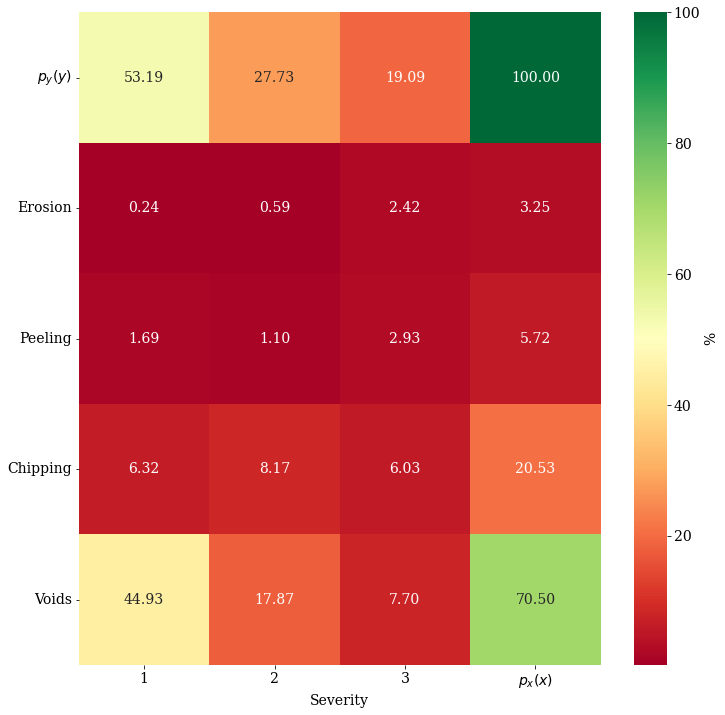

Filtering for potential speed > 65.22 we are now going from 9929 to 2491 defects


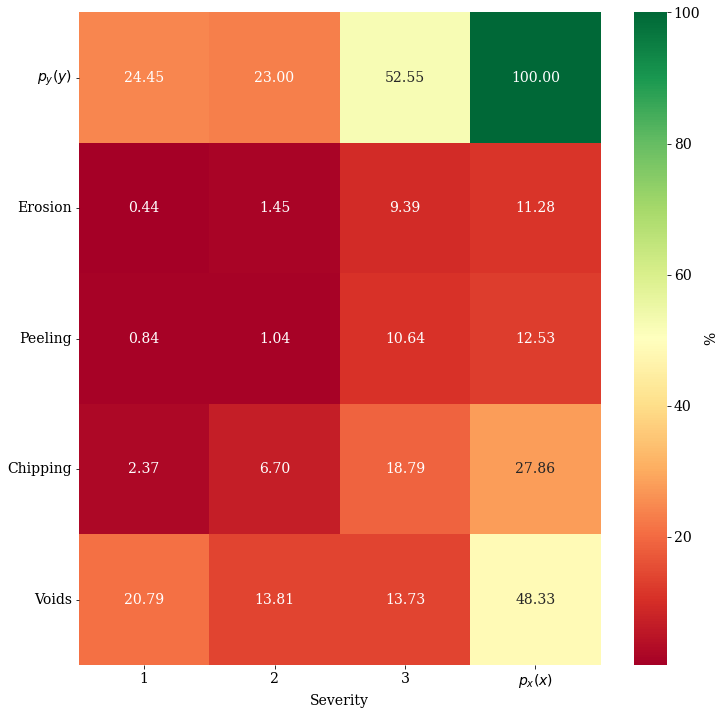

In [7]:
conditions = (
    (X_raw['Surface area']=='LE') & # only looking at leading edge defects
    (X_raw['Potential speed']>0) & # potential speed greater or equal to 65 m/s (corresponds roughly to outer 20% of blade)
    (X_raw['Type'].isin(['Voids', 'Chipping', 'Peeling', 'Erosion']))  # only looking at the four defect types
)
X_filt = X_raw[conditions]
# dropping nan
X_filt = X_filt.dropna(subset=['Type', 'Severity'], inplace=False)
# Converting roman severity into numerical
X_filt = X_filt.replace(['I', 'II', 'III', 'IV', 'V'], [1, 2, 3, 4, 5])
# convert severity to int
X_filt = X_filt.astype({'Severity': int})
# replace type with numerical value
X_filt = X_filt.replace(['Voids','Chipping','Peeling','Erosion'], [1, 2, 3, 4])
# drop defects that have type <4 and severity >3
conditions = (
    (X_filt['Type']<4) &
    (X_filt['Severity']>3)
)
X_filt = X_filt[~conditions]
print('Simple filter, we are now going from', len(X_raw), 'to', len(X_filt), 'defects')
HF.plot_marginal_distribution(X_filt)
X_filt2 = X_filt[X_filt['Potential speed']>X_filt['Potential speed'].max()*0.8]
print('Filtering for potential speed >',round(X_filt['Potential speed'].max()*0.8, 2), 'we are now going from', len(X_filt), 'to', len(X_filt2), 'defects')
HF.plot_marginal_distribution(X_filt2)
#X_filt = X_filt2

Now we add a weigth to each defect based on the weighting scheme shown below:

In [8]:
# adding weights
weights = pd.read_excel('data/project_data.xlsx', usecols=[0,1,2,3], sheet_name='damage weights')
D = []
for i in range(len(X_filt)):
    tmp = X_filt.iloc[i]
    cond = (
        (weights['Type']==tmp['Type'])&
        (weights['Severity']==tmp['Severity'])
    )
    D.append(weights[cond]['Weight'].values[0])
X_filt['Weight'] = np.array(D)
X_filt.to_pickle('data/filtered_defects.pkl')

Now we will add a bunch of different defect statistics to evaluate which damage metric is better to use and matches the weather data the best:

In [27]:
# add standard format
X_wf = pd.DataFrame()
for wf in X_unique_blades['WF'].unique():
    for year in X_unique_blades[X_unique_blades['WF']==wf]['year'].unique():
        cond = (
            (X_unique_blades['WF']==wf) &
            (X_unique_blades['year']==year)
        )
        df = X_unique_blades[cond]
        cols = {
            'WF': wf,
            'year': year,
            'total turbines': X_info[X_info['Name']==wf]['No WTG'].values[0],
            'inspected turbines': len(df['WTG'].unique()),
            'total blades': X_info[X_info['Name']==wf]['No blades'].values[0],
            'inspected blades': len(df),
        }
        X_wf = X_wf.append(cols, ignore_index=True)
X_wf = X_wf[['WF', 'year', 'total turbines', 'inspected turbines', 'total blades', 'inspected blades']]

# add directly wf inspection mean and std of weight, type and severity
tmp = pd.DataFrame()
for idx, row in X_wf.iterrows():
    cond = (
        (X_filt['WF']==row['WF']) &
        (X_filt['year']==row['year'])
    )
    df = X_filt[cond]
    cols = {
        'defects': len(df),
        #'01_mu_W': df['Weight'].mean(),
        '01_mu_T': df['Type'].mean(),
        '01_mu_S': df['Severity'].mean(),
        #'01_sd_W': df['Weight'].std(),
        '01_sd_T': df['Type'].std(),
        '01_sd_S': df['Severity'].std(),
    }
    tmp = tmp.append(cols, ignore_index=True)
tmp = tmp.fillna(0)
X_wf = pd.concat([X_wf, tmp], axis=1)

# add stepwise wf inspection mean and std of weight, type and severity
###### go from per-defect to per-blade
X_blade = pd.DataFrame()
for index, row in X_unique_blades.iterrows():
    condition = (
        (X_filt['WF']==row['WF']) &
        (X_filt['year']==row['year']) &
        (X_filt['WTG ID']==row['WTG']) &
        (X_filt['Blade']==row['Blade'])
    )
    tmp = X_filt[condition]
    cols = {
        'WF': row['WF'],
        'year': row['year'],
        'WTG': row['WTG'],
        'Blade': row['Blade'],
        'mu_W': tmp['Weight'].mean(),
        'mu_T': tmp['Type'].mean(),
        'mu_S': tmp['Severity'].mean(),
        'sd_W': tmp['Weight'].std(),
        'sd_T': tmp['Type'].std(),
        'sd_S': tmp['Severity'].std(),
        'max_W': tmp['Weight'].max(),
    }
    X_blade = X_blade.append(cols, ignore_index=True)
"""
###### go from per-blade to per-wtg
X_wtg = pd.DataFrame()
for idx, row in X_wf.iterrows():
    cond = (
        (X_blade['WF']==row['WF']) &
        (X_blade['year']==row['year'])
    )
    df = X_blade[cond]
    for wtg in df['WTG'].unique():
        tmp = df[df['WTG']==wtg]
        cols = {
            'WF': row['WF'],
            'year': row['year'],
            'WTG': wtg,
            'mu_W': tmp['mu_W'].mean(),
            'mu_T': tmp['mu_T'].mean(),
            'mu_S': tmp['mu_S'].mean(),
            'mu_max_W': tmp['max_W'].mean(),
        }
        X_wtg = X_wtg.append(cols, ignore_index=True)
###### go from per-wtg to per-wf
X = pd.DataFrame()
for idx, row in X_wf.iterrows():
    cond = (
        (X_wtg['WF']==row['WF']) &
        (X_wtg['year']==row['year'])
    )
    df = X_wtg[cond]
    cols = {
        '02_mu_W': df['mu_W'].mean(),
        '02_mu_max_W': df['mu_max_W'].mean(),
        #'02_mu_T': df['mu_T'].mean(),
        #'02_mu_S': df['mu_S'].mean(),
    }
    X = X.append(cols, ignore_index=True)
X = X.fillna(0)
X_wf = pd.concat([X_wf, X], axis=1)
"""
X = pd.DataFrame()
for idx, row in X_wf.iterrows():
    cond = (
        (X_blade['WF']==row['WF']) &
        (X_blade['year']==row['year'])
    )
    df = X_blade[cond]
    cols = {
        '02_mu_W': df['mu_W'].mean(),
        '02_mu_max_W': df['max_W'].mean(),
        #'02_mu_T': df['mu_T'].mean(),
        #'02_mu_S': df['mu_S'].mean(),
    }
    X = X.append(cols, ignore_index=True)
X = X.fillna(0)
X_wf = pd.concat([X_wf, X], axis=1)
X_wf

,WF,year,total turbines,inspected turbines,total blades,inspected blades,defects,01_mu_T,01_mu_S,01_sd_T,01_sd_S,02_mu_W,02_mu_max_W
0,Tween Bridge,2017,22.0,7.0,66.0,20.0,253.0,1.355731,1.612648,0.886370,0.672709,0.083276,0.207647
1,Løgtved,2019,3.0,1.0,9.0,2.0,25.0,1.200000,1.240000,0.408248,0.522813,0.052675,0.200000
2,Løgtved,2018,3.0,1.0,9.0,3.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Princess Amalia,2018,60.0,10.0,180.0,19.0,262.0,1.675573,2.583969,0.771682,0.611677,0.280564,0.468421
4,Princess Amalia,2019,60.0,49.0,180.0,138.0,957.0,1.824451,2.175549,0.908184,0.894256,0.290020,0.502463
5,Princess Amalia,2020,60.0,50.0,180.0,141.0,492.0,2.335366,2.538618,1.006764,0.728062,0.397662,0.564104
6,Camster,2018,25.0,24.0,75.0,72.0,441.0,1.750567,2.455782,1.200911,0.728304,0.267701,0.686806
7,Brorstrup,2019,2.0,2.0,6.0,6.0,17.0,3.000000,2.941176,0.612372,0.242536,0.530556,0.633333
8,Märkische Heide,2019,8.0,8.0,24.0,23.0,30.0,3.066667,2.366667,1.048261,0.614948,0.472619,0.538095
9,Märkische Heide,2016,8.0,7.0,24.0,19.0,14.0,2.142857,2.214286,0.949262,0.578934,0.282273,0.295455


Convert from per-inspection into per-sequence:

In [28]:
W0, dW, W02, dW2 = [], [], [], []
for idx, row in X_info.iterrows():
    tmp = X_wf[X_wf['WF']==row['Name']]
    for i in list(combinations(row['Inspections'].split(','), 2)):
        #print(i[0][:4], i[1][:4], tmp['year'].unique())
        # if the period is between two inspections
        if i[0][:4] in tmp['year'].unique():
            #print('totals trick')
            W0.append(tmp[tmp['year']==i[0][:4]]['02_mu_W'].values[0])
            dW.append(tmp[tmp['year']==i[1][:4]]['02_mu_W'].values[0] - 
                      tmp[tmp['year']==i[0][:4]]['02_mu_W'].values[0])
            W02.append(tmp[tmp['year']==i[0][:4]]['02_mu_max_W'].values[0])
            dW2.append(tmp[tmp['year']==i[1][:4]]['02_mu_max_W'].values[0] - 
                      tmp[tmp['year']==i[0][:4]]['02_mu_max_W'].values[0])
        # else the period is between commission and inspection
        else:
            #print('commission date')
            W0.append(0)
            dW.append(tmp[tmp['year']==i[1][:4]]['02_mu_W'].values[0])
            W02.append(0)
            dW2.append(tmp[tmp['year']==i[1][:4]]['02_mu_max_W'].values[0])
X_tt['W0'] = np.array(W0)
X_tt['dW'] = np.array(dW)
X_tt['W'] = X_tt['W0'] + X_tt['dW']
X_tt['W02'] = np.array(W02)
X_tt['dW2'] = np.array(dW2)
X_tt['W2'] = X_tt['W02'] + X_tt['dW2']
X_tt.to_csv('data/processed_damage_NEWA.csv', index=False)
X_tt

,WF,start date,end date,months,t_scaler,prec_sum,ws_sum,tke_sum,prec_mean,ws_mean,tke_mean,impingement,da_inc,W0,dW,W,W02,dW2,W2
0,Brorstrup,2012-01-01,2019-05-01,88.0,1.26,6433.538273,461307.060595,58078.544265,0.128985,9.248708,1.164412,96.005915,0.786705,0.000000,0.530556,0.530556,0.000000,0.633333,0.633333
1,Løgtved,2016-06-01,2018-05-01,23.0,1.00,1237.562318,143919.129525,9064.112082,0.075319,8.759000,0.551647,20.541667,0.116657,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Løgtved,2016-06-01,2019-05-01,35.0,1.00,1758.937686,210339.803826,16799.441743,0.070147,8.388427,0.669968,29.199881,0.156682,0.000000,0.052675,0.052675,0.000000,0.200000,0.200000
3,Løgtved,2018-05-01,2019-05-01,12.0,1.00,521.375368,66430.016633,7735.568618,0.060309,7.684212,0.894803,8.658213,0.040025,0.000000,0.052675,0.052675,0.000000,0.200000,0.200000
4,Tween Bridge,2012-03-01,2017-09-01,66.0,1.33,3523.168521,300681.228387,35457.630242,0.099999,8.534322,1.006404,52.078595,0.299888,0.000000,0.083276,0.083276,0.000000,0.207647,0.207647
5,Märkische Heide,2009-05-01,2016-05-01,84.0,2.49,4106.410059,415622.383524,41458.311973,0.170809,17.288066,1.724484,62.552778,0.585163,0.000000,0.282273,0.282273,0.000000,0.295455,0.295455
6,Märkische Heide,2009-05-01,2019-05-01,120.0,1.72,5866.043133,592357.076532,57021.883915,0.117617,11.877072,1.143319,90.353759,0.829741,0.000000,0.472619,0.472619,0.000000,0.538095,0.538095
7,Märkische Heide,2016-05-01,2019-05-01,36.0,1.00,1759.152528,177269.203133,16480.181809,0.068094,6.861857,0.637926,27.376590,0.247092,0.282273,0.190346,0.472619,0.295455,0.242641,0.538095
8,Princess Amalia,2013-05-01,2018-05-01,60.0,1.04,4119.002753,383803.786882,20797.127892,0.100434,9.358329,0.507099,71.582376,1.226624,0.000000,0.280564,0.280564,0.000000,0.468421,0.468421
9,Princess Amalia,2013-05-01,2019-05-01,72.0,1.03,4711.439212,460751.225546,23564.837998,0.094991,9.289527,0.475107,82.377549,1.416901,0.000000,0.290020,0.290020,0.000000,0.502463,0.502463


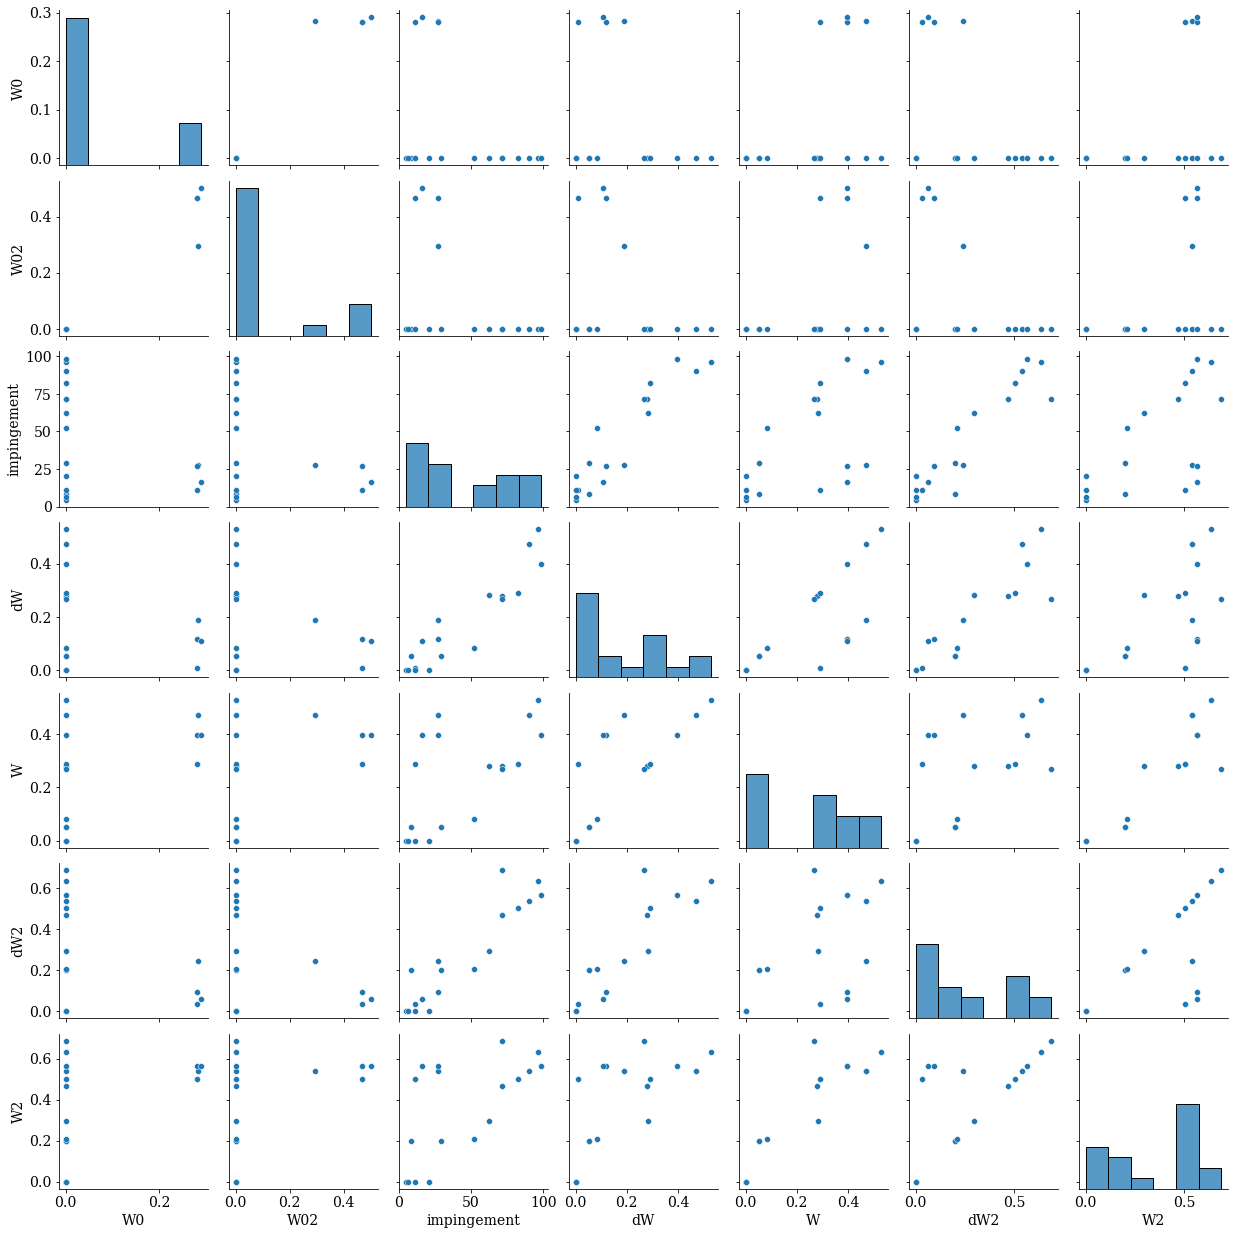

In [29]:
#plotting_features = ['seq_len','W0','prec_sum','ws_sum','hr_count','max_TS', 'coating_score','dW']
sns.pairplot(X_tt[['W0','W02','impingement','dW','W','dW2','W2']])
plt.show()

PA 2018


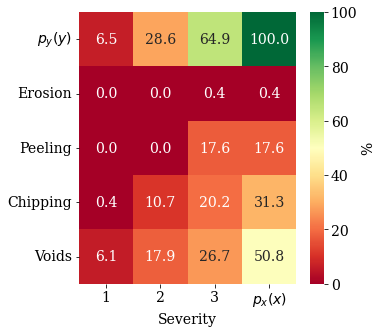

PA 2019


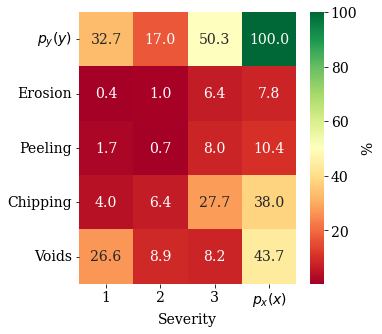

PA 2020


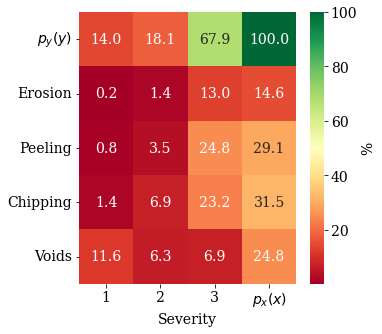

MH 2016


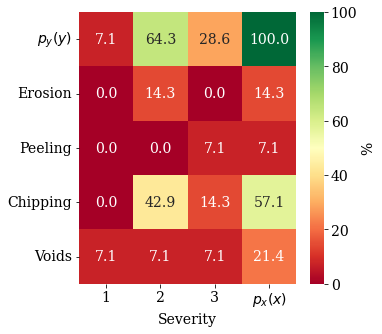

MH 2019


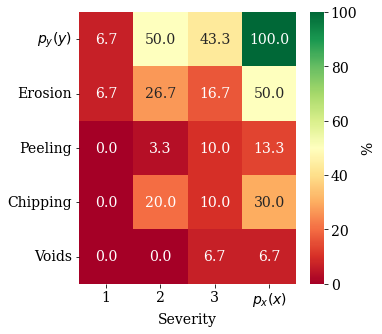

In [14]:
print('PA 2018')
HF.plot_marginal_distribution(X_filt[((X_filt['WF']=='Princess Amalia')&(X_filt['year']=='2018'))])
print('PA 2019')
HF.plot_marginal_distribution(X_filt[((X_filt['WF']=='Princess Amalia')&(X_filt['year']=='2019'))])
print('PA 2020')
HF.plot_marginal_distribution(X_filt[((X_filt['WF']=='Princess Amalia')&(X_filt['year']=='2020'))])
print('MH 2016')
HF.plot_marginal_distribution(X_filt[((X_filt['WF']=='Märkische Heide')&(X_filt['year']=='2016'))])
print('MH 2019')
HF.plot_marginal_distribution(X_filt[((X_filt['WF']=='Märkische Heide')&(X_filt['year']=='2019'))])

## Decoding
We are now making a decoding model that takes a

In [15]:
X_decode = X_wf[['01_mu_W', '01_mu_T', '01_mu_S', '01_sd_T', '01_sd_S']]
# add dummy row
new_row = {
    '01_mu_W': 1,
    '01_mu_T': 4,
    '01_mu_S': 4,
    '01_sd_T': 0,
    '01_sd_S': 0,
}
X_decode = X_decode.append(new_row, ignore_index=True)
x = X_decode['01_mu_W'].values.ravel()
y = X_decode[['01_mu_T', '01_mu_S', '01_sd_T', '01_sd_S']].values
interp_func = interpolate.interp1d(x, y, kind='slinear', axis=0)
stat = np.empty((50, 4))
x_interp = np.linspace(0, 1)
idx = 0
for D in x_interp:
    stat[idx, :] = interp_func(D)
    idx += 1
font = {'family' : 'serif',
        'size'   : 12}
plt.rc('font', **font)

fig = plt.figure(figsize=[14,10]) # [14,8.2] = full size
# Plot damage vs starting damage (fixed date range)
ax = plt.subplot(221) # 1 rows x 2 columns subplot no. 1
plt.scatter(X_wf['01_mu_W'], X_wf['01_mu_T'], s=50)
plt.plot(x_interp, stat[:,0], linestyle='dashed', color='r')
ax.grid(b=True, which='major')
ax.set_ylabel(r'mean defect type [-]')
ax.set_xlabel(r'encoded damage [-]')
ax = plt.subplot(222) # 1 rows x 2 columns subplot no. 1
plt.scatter(X_wf['01_mu_W'], X_wf['01_sd_T'], s=50)
plt.plot(x_interp, stat[:,2], linestyle='dashed', color='r')
ax.grid(b=True, which='major')
ax.set_ylabel(r'std of defect type [-]')
ax.set_xlabel(r'encoded damage [-]')
ax = plt.subplot(223) # 1 rows x 2 columns subplot no. 1
plt.scatter(X_wf['01_mu_W'], X_wf['01_mu_S'], s=50)
plt.plot(x_interp, stat[:,1], linestyle='dashed', color='r')
ax.grid(b=True, which='major')
ax.set_ylabel(r'mean defect severity [-]')
ax.set_xlabel(r'encoded damage [-]')
ax = plt.subplot(224) # 1 rows x 2 columns subplot no. 1
plt.scatter(X_wf['01_mu_W'], X_wf['01_sd_S'], s=50)
plt.plot(x_interp, stat[:,3], linestyle='dashed', color='r')
ax.grid(b=True, which='major')
ax.set_ylabel(r'std of defect severity [-]')
ax.set_xlabel(r'encoded damage [-]')
plt.show()

KeyError: "['01_mu_W'] not in index"

In [ ]:
def expected_distribution(da, interp_func):
    # DEFECT TYPE
    Dbins = np.array([-1000, 0.5, 1.5, 2.5, 3.5, 1000])
    Sbins = np.array([-1000, 0.5, 1.5, 2.5, 1000])
    Dm = np.arange(0, 5)
    Sm = np.arange(0, 4)
    m1, m2, s1, s2 = interp_func(da)
    df = pd.DataFrame()
    for i in range(len(Dbins)-1):
        D = stats.norm.cdf(Dbins[i+1], m1, s1) - stats.norm.cdf(Dbins[i], m1, s1)
        for j in range(len(Sbins)-1):
            S = stats.norm.cdf(Sbins[j+1], m2, s2) - stats.norm.cdf(Sbins[j], m2, s2)
            cols = {
                'Type': Dm[i],
                'Severity': Sm[j],
                'P': (100*D*S/1)
            }
            df = df.append(cols, ignore_index=True)
    cond = (df['Severity']!=0) & (df['Type']!=0)
    df = df[cond]
    df = df.pivot('Type', 'Severity', 'P')
    # Plot Heatmap
    font = {'family' : 'serif',
            'size'   : 14}
    plt.rc('font', **font)
    fig = plt.figure(figsize=[6,6]) # [14,8.2] = full size
    ax = plt.subplot(111)
    ax = sns.heatmap(df, 
                    cmap='RdYlGn',
                    square=True,
                    annot=True,
                    fmt='.0f',
                    yticklabels=['Voids', 'Chipping', 'Peeling', 'Erosion'],
                    cbar_kws={'label': 'Probability [%]'})
    ax.set_ylabel('')
    ax.tick_params(axis='y', rotation=0)
    ax.invert_yaxis()
    plt.title('Predicted distribution')
    plt.show()

In [ ]:
expected_distribution(0.37, interp_func)

In [ ]:
# load weighting scheme
df = pd.read_excel('data/project_data.xlsx', sheet_name='damage weights')
df = df[['Defect', 'Type', 'Severity', 'Weight']]
# specify model prediction
mu = 0.5
sd = 0.3
# calculate distance to each weight
df['Distance'] = df['Weight']-mu
# Calculate weights based on a normal distribution
df['Prob_norm'] = stats.norm.pdf(df['Distance'].values, loc=0, scale=sd)
# scale
df['Prob_norm'] = 100*df['Prob_norm']/df['Prob_norm'].sum()


# Plot distribution
weight = df.pivot('Type', 'Severity', 'Prob_norm')
# Plot Heatmap
font = {'family' : 'serif',
        'size'   : 14}
plt.rc('font', **font)
fig = plt.figure(figsize=[6,6]) # [14,8.2] = full size
ax = plt.subplot(111)
ax = sns.heatmap(weight, 
                 cmap='RdYlGn',
                 square=True,
                 annot=True,
                 fmt='.0f',
                 yticklabels=['Voids', 'Chipping', 'Peeling', 'Erosion'],
                 cbar_kws={'label': 'Weight'})
ax.set_ylabel('')
ax.tick_params(axis='y', rotation=0)
ax.invert_yaxis()
#plt.title(r'Defect weighting scheme')
plt.show()

In [ ]:
X_dist = pd.DataFrame()
for t in np.arange(1, 5):
    for s in np.arange(1, 4):
        cond = (
            (X_filt['Type']==t) &
            (X_filt['Severity']==s)
        )
        #tmp = df[cond]
        cols = {
            'Severity': s,
            'Type': t,
            'n': cond.sum(),
        }
        X_dist = X_dist.append(cols, ignore_index=True)
X_dist['N'] = 100*X_dist['n']/X_dist['n'].sum()
weight = X_dist.pivot('Type', 'Severity', 'N')
# Plot Heatmap
font = {'family' : 'serif',
        'size'   : 14}
plt.rc('font', **font)
fig = plt.figure(figsize=[5,5]) # [14,8.2] = full size
ax = plt.subplot(111)
ax = sns.heatmap(weight, 
                 cmap='RdYlGn',
                 square=True,
                 annot=True,
                 fmt='.1f',
                 yticklabels=['Voids', 'Chipping', 'Peeling', 'Erosion'],
                 cbar_kws={'label': '%'})
ax.set_ylabel('')
ax.tick_params(axis='y', rotation=0)
ax.invert_yaxis()
plt.show() 